In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
!unzip -q "/content/drive/My Drive/The Cool Kids/Data/CheXpert-v1.0-small.zip"

In [4]:
import os
import numpy as np
import pandas as pd
import math

import tensorflow as tf
from keras.layers import Input, Dense, Convolution2D, Flatten, Concatenate, MaxPooling2D, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


from contextlib import redirect_stdout
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

Using TensorFlow backend.


## Global Variables

In [0]:
outcomes = ['No Finding',
            'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']

pathologies = ['Lung Opacity', 'Support Devices', 'Pleural Effusion', 'Atelectasis', 'Cardiomegaly']


PATH = '/content/CheXpert-v1.0-small'
target = pathologies

image_size = 256
train_batch_size = 64
val_batch_size = 64
test_batch_size = 234

lr = 0.0001 #learning rate
num_steps_per_epoch = 2500 #can be set to none for auto choosing
num_epochs = 30

threshold = 0.5

#create the directory before you start!
model_name = 'five_labels'
model_directory = 'regularize2/' #model_name+‘/’
if os.path.isdir(model_directory):
  print('Did you mean to rename the model?')
  if not os.path.isdir(model_directory+'checkpoints/'):
    os.makedirs(model_directory+ 'checkpoints/')
else:
  os.makedirs(model_directory)
  os.makedirs(model_directory+'checkpoints/')

## Preprocessing

In [0]:
def edit_urls(url):
    ''' a function to edit the urls to the correct path using a global PATH variable declared earlier
    '''
    pieces = url.split('/')
    newurl = ''

      #removing the previous path 'CheXpert-v1.0-small' and including the PATH
    for i, piece in enumerate(pieces):
        if i > 0:
            newurl+= '/' + piece
        elif i == 0:
            newurl += PATH

    return newurl

def clean_data(df):
    '''
    Edits the urls, fills the 'maybes' with yes and the nulls with no,
    removes outlier ages (age 0 patients), removes 'unknown gender' patients,
    collects which type of image it is
    '''
    df['Path'] = df['Path'].apply(edit_urls)
    df[outcomes] = df[outcomes].fillna(0)
    df[outcomes] = df[outcomes].replace(-1,1)
    return df

  
  
  
def stratify_training_set(df):
    '''
    Groups by the target so the training set has equal amounts of 'yes target' and 'no target'
    '''
    notarg = df[ df[target] == 0 ]
    yestarg = df[ df[target] == 1]
    print(f'There are {len(yestarg)} patients with {target}, compared to {len(notarg)} patients in the dataset without {target}')
    print(f'{100* len(yestarg) / len(df)}% of patients have {target}')
    if len(notarg) > len(yestarg):
        print(f'{(len(notarg) - len(yestarg))} ({100*(len(notarg) - len(yestarg))/len(notarg)}%) of patients without {target} will be randomly removed from the sample pool')
        notarg = notarg.sample(len(yestarg))
    else:
        print(f'{(len(yestarg) - len(notarg))} ({100*(len(yestarg) - len(notarg))/len(yestarg)}%)  of patients with {target} will be randomly removed from the sample pool')
        yestarg = yestarg.sample(len(notarg))
        
    traindf = pd.concat([yestarg, notarg], axis=0)
    traindf = traindf.sample(frac=1)
    
    return traindf

In [7]:


train_df = clean_data(pd.read_csv(PATH + '/train.csv'))
test_df = clean_data(pd.read_csv(PATH + '/valid.csv'))
num_test_df = test_df[pathologies]
#train_df[outcomes].head()
#can chose a subset here

#stratify the training set by the target
#train_df = stratify_training_set(train_df)

#set sample size
#train_df = train_df.sample(10000)

#for keras, make the target a string
# train_df[pathologies] = train_df[pathologies].astype(str)
# test_df[pathologies] = test_df[pathologies].astype(str)

print('test set:', test_df.shape)
print('training set:', train_df.shape)

test set: (234, 19)
training set: (223414, 19)


## Prepare the Model

In [8]:
datagen = ImageDataGenerator(
   rescale = 1./255,
   validation_split = 0.2
)

train_generator = datagen.flow_from_dataframe(
   train_df,
   x_col='Path',
   y_col=pathologies,
   color_mode='grayscale', # images will be converted to have 1 color channel
   target_size=(image_size, image_size), #The dimensions to which all images found will be resized
   class_mode='other', # Mode for yielding the targets 1D numpy array of binary labels,if class_mode is "binary" it must include the given y_col column with class values as strings.
   batch_size=train_batch_size,
   subset = "training"
   #shuffle: whether to shuffle the data (default: True)
)

validation_generator = datagen.flow_from_dataframe(
   train_df,
   x_col='Path',
   y_col=pathologies,
   target_size=(image_size, image_size),
   color_mode='grayscale',
   class_mode='other',
   batch_size=val_batch_size,
   subset = "validation"
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='Path',
    y_col=pathologies,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    class_mode=None,
    batch_size=test_batch_size,
    shuffle = False #just in case
)

Found 178732 validated image filenames.
Found 44682 validated image filenames.
Found 234 validated image filenames.


## Edit your model here

### To create a model

In [0]:
#We create a Sequential model using 'categorical cross-entropy' as our loss function and 'adam' as the optimizer.

from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers



model = Sequential()
model.add(Conv2D(32, (3, 3),input_shape=(256,256,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='sigmoid')) #do not forget to change for correct number of labels


model.compile(optimizers.adam(lr=0.0001),loss="binary_crossentropy",metrics=["accuracy"])

## Run the model

### Train the model

(only necessary when you are creating a model, not loading a model)

In [10]:
# uses some global variables
history = model.fit_generator(train_generator,
                              steps_per_epoch = 2700, 
                              epochs = 10,
                              validation_data = validation_generator,
                              validation_steps=700)

Epoch 1/10
2700/2700 [==============================] - 984s 364ms/step - loss: 0.5860 - acc: 0.6877 - val_loss: 0.5592 - val_acc: 0.7122
Epoch 2/10
2700/2700 [==============================] - 977s 362ms/step - loss: 0.5671 - acc: 0.7036 - val_loss: 0.5492 - val_acc: 0.7197
Epoch 3/10
2700/2700 [==============================] - 967s 358ms/step - loss: 0.5581 - acc: 0.7112 - val_loss: 0.5411 - val_acc: 0.7247
Epoch 4/10
2700/2700 [==============================] - 964s 357ms/step - loss: 0.5517 - acc: 0.7162 - val_loss: 0.5350 - val_acc: 0.7291
Epoch 5/10
2700/2700 [==============================] - 977s 362ms/step - loss: 0.5458 - acc: 0.7199 - val_loss: 0.5298 - val_acc: 0.7321
Epoch 6/10
2700/2700 [==============================] - 964s 357ms/step - loss: 0.5425 - acc: 0.7230 - val_loss: 0.5277 - val_acc: 0.7340
Epoch 7/10
2700/2700 [==============================] - 958s 355ms/step - loss: 0.5388 - acc: 0.7255 - val_loss: 0.5242 - val_acc: 0.7352
Epoch 8/10
2700/2700 [============

## Save the model

In [11]:
model.save(model_directory + model_name + '.h5')
print('Model saved in', model_directory)

Model saved in regularize2/


### Make Predictions

(be patient)

In [13]:
# probabillity predcitions from test_generator

predictions = model.predict_generator(test_generator, steps = len(test_generator))
print(f'made {len(predictions)} predictions')

made 234 predictions


In [14]:
# actual dataframe (not str) 
#num_test_df.head()

#create a numpy.array from test_df
actual_values = np.array(num_test_df)
actual_values = actual_values.astype(int)


pred_bool = (predictions > 0.5)
predictions_bool = pred_bool.astype(int)
#test if correct output
print(actual_values[:11])
print()
print(predictions_bool[:11])

[[1 0 0 0 1]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 1 1 0]
 [1 1 0 1 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 1 1 1]]

[[0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 0 0 0]
 [0 0 0 0 0]
 [1 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 1 0 0]]


In [15]:
#get predictions >0.5 and print a table of all 234 predictions
pred_bool = (predictions > 0.5)
predictions_bool = pred_bool.astype(int)
print(type(predictions_bool))

pathologies = ['Lung Opacity', 'Support Devices', 'Pleural Effusion', 'Atelectasis', 'Cardiomegaly']

#columns should be the same order of y_col
results=pd.DataFrame(predictions_bool, columns=pathologies)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+pathologies
results=results[ordered_cols]#To get the same column order
results[0:3]

<class 'numpy.ndarray'>


,Filenames,Lung Opacity,Support Devices,Pleural Effusion,Atelectasis,Cardiomegaly
0,/content/CheXpert-v1.0-small/valid/patient6454...,0,1,0,0,0
1,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,0,0,0
2,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,0,0,0


## History of the model

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


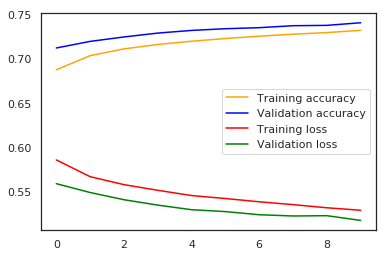

In [18]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

## Do metrics

In [19]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix


mcm = multilabel_confusion_matrix(actual_values, predictions_bool)
TN = mcm[:, 0, 0]
TP = mcm[:, 1, 1]
FN = mcm[:, 1, 0]
FP = mcm[:, 0, 1]

multilabel_confusion_matrix(actual_values, predictions_bool)


array([[[ 89,  19],
        [ 44,  82]],

       [[ 88,  39],
        [ 33,  74]],

       [[149,  18],
        [ 28,  39]],

       [[154,   0],
        [ 77,   3]],

       [[166,   0],
        [ 65,   3]]])

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

roc_auc_score(actual_values, predictions)
print(classification_report(actual_values, predictions_bool))

              precision    recall  f1-score   support

           0       0.81      0.65      0.72       126
           1       0.65      0.69      0.67       107
           2       0.68      0.58      0.63        67
           3       1.00      0.04      0.07        80
           4       1.00      0.04      0.08        68

   micro avg       0.73      0.45      0.55       448
   macro avg       0.83      0.40      0.44       448
weighted avg       0.82      0.45      0.48       448
 samples avg       0.45      0.36      0.38       448



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [21]:
print(predictions[0:10])
print(actual_values[0:10])

[[0.34984487 0.5324042  0.11410362 0.2931456  0.0842545 ]
 [0.1716136  0.24051565 0.08385971 0.06568843 0.01455876]
 [0.1923325  0.2703084  0.05674371 0.04596666 0.0266743 ]
 [0.5580803  0.6579716  0.4681877  0.1901046  0.1353637 ]
 [0.25017297 0.35151228 0.04391825 0.13247144 0.02246177]
 [0.61866117 0.4837149  0.6996341  0.47121587 0.035005  ]
 [0.4740951  0.6493416  0.26296368 0.3836132  0.06187877]
 [0.24958172 0.3750506  0.14813596 0.11635318 0.0232366 ]
 [0.47063774 0.3357064  0.25482488 0.24310705 0.04988769]
 [0.35907218 0.23431864 0.1448364  0.0781675  0.06994823]]
[[1 0 0 0 1]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 1 1 0]
 [1 1 0 1 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


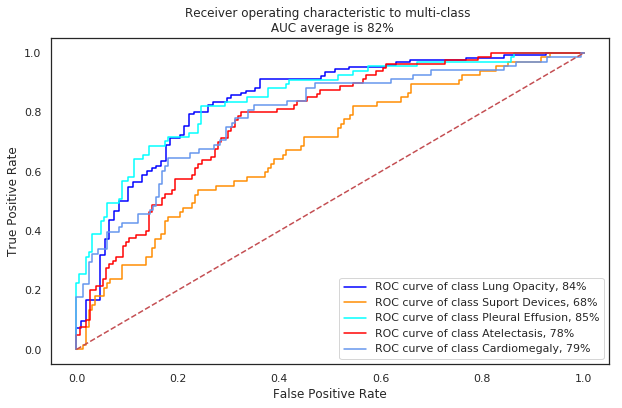

0.8390652557319224 0.6829922245062114 0.8462775940656001 0.7770292207792209 0.7873848334514529


In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

# graphing lung opacity - lung_opacity_actuals

lung_opacity = []
for i in range(len(predictions)):
  lung_opacity.append(predictions[i][0])
lung_opacity = np.array(lung_opacity)
lung_opacity_actuals = []
for i in range(len(actual_values)):
  lung_opacity_actuals.append(actual_values[i][0])
lung_opacity_actuals= np.array(lung_opacity_actuals)


# graphing lung opacity - support_devices

support_devices = []
for i in range(len(predictions)):
  support_devices.append(predictions[i][1])
support_devices = np.array(support_devices)

support_devices_actuals = []
for i in range(len(actual_values)):
  support_devices_actuals.append(actual_values[i][2])
support_devices_actuals= np.array(support_devices_actuals)




# graphing lung opacity - pleural_effusion

pleural_effusion = []
for i in range(len(predictions)):
  pleural_effusion.append(predictions[i][2])
pleural_effusion = np.array(pleural_effusion)

pleural_effusion_actuals = []
for i in range(len(actual_values)):
  pleural_effusion_actuals.append(actual_values[i][2])
pleural_effusion_actuals= np.array(pleural_effusion_actuals)



# graphing lung opacity - atelectasis

atelectasis = []
for i in range(len(predictions)):
  
  atelectasis.append(predictions[i][3])
atelectasis = np.array(atelectasis)

atelectasis_actuals = []
for i in range(len(actual_values)):
  atelectasis_actuals.append(actual_values[i][3])
atelectasis_actuals= np.array(atelectasis_actuals)


# graphing lung opacity - cardiomegaly

cardiomegaly = []
for i in range(len(predictions)):
  cardiomegaly.append(predictions[i][4])
cardiomegaly = np.array(cardiomegaly)
cardiomegaly_actuals = []
for i in range(len(actual_values)):
  cardiomegaly_actuals.append(actual_values[i][4])
cardiomegaly_actuals= np.array(cardiomegaly_actuals)



plt.subplots(figsize = (10, 6))

FPR1, TPR1, thresholds = roc_curve(lung_opacity_actuals, lung_opacity)
AUC_1 = roc_auc_score(lung_opacity_actuals, lung_opacity)
plt.plot(FPR1, TPR1, "blue", label = 'ROC curve of class Lung Opacity, 84%')


FPR2, TPR2, thresholds = roc_curve(support_devices_actuals, support_devices)
AUC_2 = roc_auc_score(support_devices_actuals, support_devices)
plt.plot(FPR2, TPR2, "darkorange", label = 'ROC curve of class Suport Devices, 68%')


FPR3, TPR3, thresholds = roc_curve(pleural_effusion_actuals, pleural_effusion)
AUC_3 = roc_auc_score(pleural_effusion_actuals, pleural_effusion)
plt.plot(FPR3, TPR3, "aqua", label = 'ROC curve of class Pleural Effusion, 85%')

FPR4, TPR4, thresholds = roc_curve(atelectasis_actuals, atelectasis)
AUC_4 = roc_auc_score(atelectasis_actuals, atelectasis)
plt.plot(FPR4, TPR4, "red", label = 'ROC curve of class Atelectasis, 78%')

FPR5, TPR5, thresholds = roc_curve(cardiomegaly_actuals, cardiomegaly)
AUC_5 = roc_auc_score(cardiomegaly_actuals, cardiomegaly)
plt.plot(FPR5, TPR5, "cornflowerblue", label = 'ROC curve of class Cardiomegaly, 79%')


plt.plot([0, 1], [0, 1], "r--")


plt.title("Receiver operating characteristic to multi-class \n AUC average is 82%")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print(AUC_1, AUC_2, AUC_3, AUC_4, AUC_5)



In [0]:
def plot_image(i, predictions, actual_values, images_bucket, threshold):
    '''
    Plots images next to labels, color coded based on if they were correct or not.
    '''
    prob_sick = predictions[i]
    true_label = int(actual_values[i])

    # Remove grid, x and y axis ticks from the chart
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Plot the image
    plt.imshow( images_bucket[i, :, :, 0], cmap='gray')

    if prob_sick > threshold:
        predicted_label = 1
    else:
        predicted_label = 0
    
    # Set color to blue on a correct prediction, otherwise set color to red
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    class_names = ['Not '+target, target ]

In [0]:
from PIL import Image
def make_prediction_barcharts(i, predictions, actual_values, images_bucket, threshold):
  plt.figure(figsize=(10,4))
  
  prob_sick = predictions[i]
  true_labels = actual_values[i]
  img_url = images_bucket.iloc[i]['Path']

  plt.subplot(1,2,1)
  
  # Remove grid, x and y axis ticks from the chart
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = Image.open(img_url)
  implot = plt.imshow(img, cmap='gray')
  
  #plot the image
  
  plt.subplot(1,2,2)
  plt.xticks([])
  thisplot = plt.bar(range(len(prob_sick)), prob_sick)

  plt.xticks(np.arange(5), ('Lung Opacity', 'Support Devices', 'Pleural Effusion', 'Atelectasis', 'Cardiomegaly'), rotation='vertical')
  plt.show()

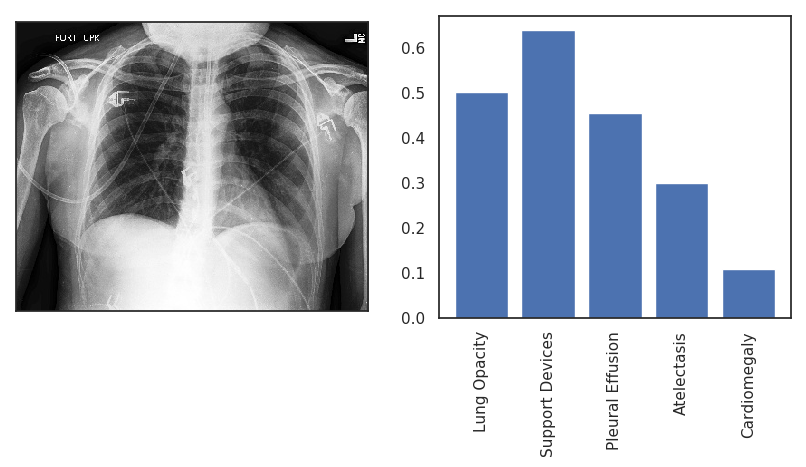

In [289]:
make_prediction_barcharts(200, predictions, actual_values, test_df, threshold)